In [836]:
# Hi Giulia
# Question 1-2 must only do fro 2008-2021!!
# Question 1; annualized returns: not done for all the years if we do *12

In [837]:
'''pip install pandas
pip install matplotlib
pip install numpy'''

'pip install pandas\npip install matplotlib\npip install numpy'

In [838]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.optimize as sco

# Create monthly dataset

In [839]:
#Monthly_reurn include 278 months and 2051 firms (rows)
M_RI_path = r'C:\Users\giuli\Documents\SEF_Homework1\SEF\ESG_Scores\DS_RI_T_USD_M.xlsx'  # Replace with your Excel file name
df_M_RI = pd.read_excel(M_RI_path)

#Monthly_capitalization include 278 months and 2051 firms 
M_cap_path = r'C:\Users\giuli\Documents\SEF_Homework1\SEF\ESG_Scores\DS_MV_USD_M.xlsx'  # Replace with your Excel file name
df_M_cap = pd.read_excel(M_cap_path)

#Country to region data
region_path = r'C:\Users\giuli\Documents\SEF_Homework1\SEF\CountriesToRegions.xlsx'  # Replace with your Excel file name
df_region = pd.read_excel(region_path)

In [840]:
#Let's keep only the EUR contries

df_region.drop(index=[0,1,2,3], inplace= True )

df_EUR = df_region[df_region['Unnamed: 2'] == 'EUR']
#Rename the column so we can merge later
df_EUR = df_EUR.rename(columns={'% AMER: Cnada + USA' : 'ISIN_First2'})

In [841]:
#Merging the datasets 
#First step: create a column with only the 2 first characters of the column ISIN

#For the return index dataset
df_M_RI['ISIN_First2'] = df_M_RI ['ISIN'].str[:2]
#df_M_RI

In [842]:
#For the capitlization dataset
df_M_cap['ISIN_First2'] = df_M_cap ['ISIN'].str[:2]
#df_M_cap

In [843]:
#Second step: merge the IR and capitalization datasets with the region dataset, keeping only EUR firms
df_EUR_M_cap = pd.merge(df_EUR,  df_M_cap, on='ISIN_First2', how='inner')
df_EUR_M_RI = pd.merge(df_EUR,  df_M_RI, on='ISIN_First2', how='inner')

In [844]:
df_EUR_M_cap.to_csv('/Users/giuli\Documents\SEF_Homework1\SEF/df_EUR_monthly_capitalization.csv', index=False)
df_EUR_M_RI.to_csv('/Users/giuli\Documents\SEF_Homework1\SEF/df_EUR_monthly_RI.csv', index=False)
#We have now 508 firms with data for 281 months (minus the first columns)

# Import monthly dataset

In [845]:
#Import monthly capitalization dataset for EUR firms
#url = "https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/main/df_EUR_monthly_capitalization.csv"
#df_EUR_M_cap = pd.read_csv(url)

In [846]:
#Import monthly return index (RI) dataset for EUR firms
#url0 = "https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/main/df_EUR_monthly_return.csv"
#df_EUR_M_RI = pd.read_csv(url0)
#df_RI_monthly

# Import yearly dataset

In [847]:
#Import yearly capitalization dataset for EUR firms
#url1 = "https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/main/df_EUR_yearly_capitalization.csv"
#df_EUR_Y_cap = pd.read_csv(url1)

In [848]:
#Import yearly return index (RI) dataset for EUR firms
#url2 = "https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/main/df_EUR_yearly_return.csv"
#df_EUR_Y_RI = pd.read_csv(url2)

# Question 1

Compute the annualized average RI and annualized volatility for all individual assets over the period 2008–2022. Plot and comment the histogram of these distributions. Compute and comment on the correlation between individual average RIs and volatilities in the cross section. (10 points)

### Annualized average return

In [849]:
df_EUR_M_cap.drop(df_EUR_M_cap.columns[:4], axis=1, inplace=True)
df_EUR_M_cap.set_index('NAME', inplace = True)
#df_EUR_M_cap_08 = df_EUR_M_cap.loc[:, (df_EUR_M_cap.columns >= "2008-01-01")]
#df_EUR_M_cap_T = df_EUR_M_cap_08.T
df_EUR_M_cap_T = df_EUR_M_cap.T
#df_EUR_M_cap_T

In [850]:
df_EUR_M_cap.dtypes

2000-01-31    float64
2000-02-29    float64
2000-03-31    float64
2000-04-30    float64
2000-05-31    float64
               ...   
2022-08-31    float64
2022-09-30    float64
2022-10-31    float64
2022-11-30    float64
2022-12-31    float64
Length: 276, dtype: object

In [851]:
df_M_returns = df_EUR_M_cap_T.pct_change()

In [852]:
df_M_returns_annualized = df_M_returns.mean() * 12

<Axes: xlabel='NAME'>

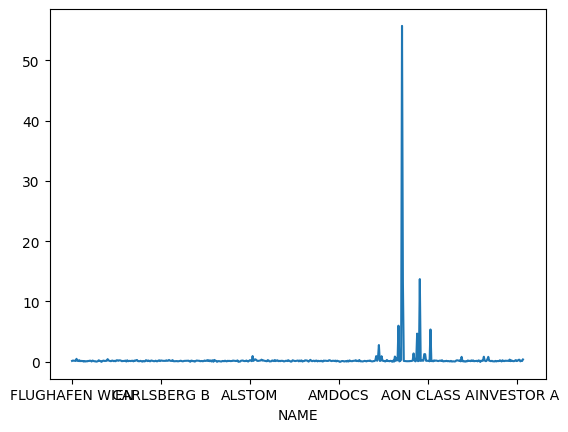

In [853]:
df_M_returns_annualized.plot()

<Axes: ylabel='Count'>

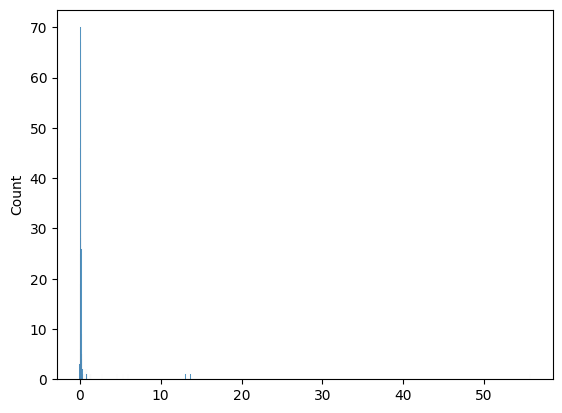

In [854]:
sns.histplot(df_M_returns_annualized)

### Annualized volatility

In [855]:
deviations = df_M_returns - df_M_returns.mean()
squared_deviations = deviations**2
mean_squared_deviations = squared_deviations.mean()

df_M_volatility = np.sqrt(mean_squared_deviations)

In [856]:
df_M_volatility_annualized = df_M_volatility*(12**0.5)

<Axes: xlabel='NAME'>

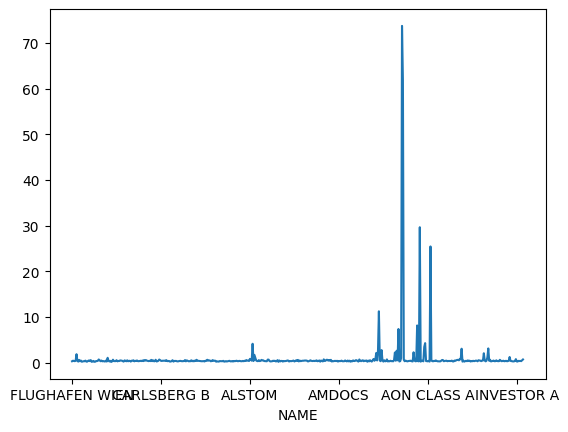

In [857]:
df_M_volatility_annualized.plot()

### Correlation

In [858]:
df = pd.DataFrame()
df["returns"] = df_M_returns_annualized

In [859]:
df["volatility"]=df_M_volatility_annualized

In [860]:
'''df.corr()
     

df["corr"] = 0
for i in df.index:
    df.loc[i, "corr"] = df.loc[i, "returns"].corr(df.loc[i, "volatility"], method="pearson")
     

df.loc[i]["corr"]'''

'df.corr()\n     \n\ndf["corr"] = 0\nfor i in df.index:\n    df.loc[i, "corr"] = df.loc[i, "returns"].corr(df.loc[i, "volatility"], method="pearson")\n     \n\ndf.loc[i]["corr"]'

# Question 3

### Create the dataset 

In [861]:
#Import score ESG (E)
E_score_url = r'C:\Users\giuli\Documents\SEF_Homework1\SEF\ESG_Scores\DS_EScore_Y.xlsx'  # Replace with your Excel file name
df_E_score = pd.read_excel(E_score_url)

In [862]:
#Create a new column with only the 2 first caracters of the column ISIN

df_E_score['ISIN_First2'] = df_E_score['ISIN'].str[:2]

In [863]:
#Create a list with the EUR countries from the EUR dataset
np_EUR = df_EUR['ISIN_First2'].unique()
list_EUR = list(np_EUR)
#list_EUR 

In [864]:
#EUR firms with E score
df_E_score_EUR = df_E_score[df_E_score['ISIN_First2'].isin(list_EUR)]
#df_E_score_EUR

In [865]:
#Keep only the years 2007-2022 and erase the 'x' in front of the year
columns_to_keep = [col for col in df_E_score_EUR.columns if not ('x1999' <= col <= 'x2006')]

df_E_score_EUR_08 = df_E_score_EUR[columns_to_keep]

df_E_score_EUR_08.columns = df_E_score_EUR_08.columns.str.replace('x', '')
#df_E_score_EUR_08

In [866]:
#Make a list with the EUR firms having an E score
df_E_score_EUR_08
np_NAME = df_E_score_EUR_08['NAME'].unique()
list_NAME = list(np_NAME)
#list_NAME
#We have 536 firms

In [867]:
#IT DOESN'T WORK
#df_E_EUR_M_RI = df_EUR_M_RI[df_EUR_M_RI.index.isin(list_NAME)]

In [868]:
#We use this dataset because it seems that all EUR firms have an E score
df_EUR_M_RI

,ISIN_First2,Unnamed: 1,Unnamed: 2,ISIN,NAME,2000-01-31 00:00:00,2000-02-29 00:00:00,2000-03-31 00:00:00,2000-04-30 00:00:00,2000-05-31 00:00:00,...,2022-03-31 00:00:00,2022-04-30 00:00:00,2022-05-31 00:00:00,2022-06-30 00:00:00,2022-07-31 00:00:00,2022-08-31 00:00:00,2022-09-30 00:00:00,2022-10-31 00:00:00,2022-11-30 00:00:00,2022-12-31 00:00:00
0,AT,AUSTRIA,EUR,AT00000VIE62,FLUGHAFEN WIEN,156.25,153.83,158.62,137.27,148.95,...,1073.50,1044.97,1035.49,1258.39,1229.26,1215.93,1190.06,1198.76,1248.90,1269.03
1,AT,AUSTRIA,EUR,AT0000652011,ERSTE GROUP BANK,94.91,97.74,100.50,96.13,97.86,...,567.30,482.13,504.75,410.92,409.07,367.15,360.26,400.68,495.04,518.33
2,AT,AUSTRIA,EUR,AT0000743059,OMV,389.64,318.75,311.41,335.24,356.91,...,4277.87,4589.77,5163.58,4341.76,3918.78,3758.17,3396.99,4277.10,4792.28,4763.37
3,AT,AUSTRIA,EUR,AT0000746409,VERBUND,524.60,564.59,518.56,463.37,498.05,...,8285.25,8406.71,7820.72,7690.07,8637.53,7555.23,6751.05,6172.06,6981.93,6614.67
4,AT,AUSTRIA,EUR,AT0000831706,WIENERBERGER,2379.46,2203.58,2451.55,2552.81,2746.80,...,6331.35,5915.37,5895.80,4581.59,4896.37,5022.24,4318.66,4894.01,5548.18,5152.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,SE,SWEDEN,EUR,SE0015988019,NIBE INDUSTRIER,17.82,18.78,19.97,19.59,19.61,...,6003.53,5299.14,4659.33,4014.61,5348.71,5050.28,4831.75,4270.62,4921.75,4991.91
504,SE,SWEDEN,EUR,SE0016589188,ELECTROLUX B,533.00,470.45,473.03,432.63,431.17,...,2196.55,2209.15,2216.31,1921.70,2046.88,1819.41,1558.19,1834.65,2072.22,2010.28
505,SE,SWEDEN,EUR,SE0017486889,ATLAS COPCO A,221.48,202.18,212.75,209.47,198.64,...,8565.58,7554.67,7456.44,6222.46,7723.51,6823.05,6300.71,7188.93,8151.37,7951.07
506,SE,SWEDEN,EUR,SE0018012494,MODERN TIMES GROUP MTG B,76.83,85.51,79.92,80.98,73.42,...,128.27,92.81,102.04,91.70,117.58,100.69,76.18,85.61,88.01,97.81


In [869]:
#Drop the first 4 columns
df_EUR_M_RI.drop(df_EUR_M_RI.columns[:4], axis=1, inplace=True)
df_EUR_M_RI.set_index('NAME', inplace = True)

#Keep only the years 2007-2022
df_EUR_M_RI = df_EUR_M_RI.loc[:, (df_EUR_M_RI.columns >= pd.to_datetime("2007-01-01"))]

#Transpose the dataset to have rows=dates, columns=names
df_EUR_M_RI_T = df_EUR_M_RI.T
df_EUR_M_RI_T


NAME,FLUGHAFEN WIEN,ERSTE GROUP BANK,OMV,VERBUND,WIENERBERGER,VIENNA INSURANCE GROUP A,VOESTALPINE,MAYR-MELNHOF KARTON,IMMOFINANZ,SOLVAY,...,FABEGE,KINNEVIK B,INVESTOR A,SWEDISH MATCH DEAD - DELIST.02/01/23,HEXAGON B,NIBE INDUSTRIER,ELECTROLUX B,ATLAS COPCO A,MODERN TIMES GROUP MTG B,BOLIDEN ORD SHS
2007-01-31 00:00:00,588.22,832.39,2664.05,2546.70,9097.39,851.97,1435.56,477.37,462.19,10112.73,...,77.42,97.55,1295.83,111.48,464.57,442.89,1215.34,1130.67,110.80,13.52
2007-02-28 00:00:00,547.79,796.16,2782.09,2219.78,9099.54,813.56,1538.25,479.43,463.40,9464.52,...,77.29,96.47,1225.14,108.90,431.28,419.34,1440.88,1042.41,97.00,12.30
2007-03-31 00:00:00,577.47,832.87,3133.16,2413.09,9219.09,826.85,1798.54,550.66,487.71,10203.70,...,81.99,107.22,1287.74,112.28,460.54,423.09,1624.53,1096.84,102.27,12.80
2007-04-30 00:00:00,645.36,864.46,3188.47,2794.73,10735.85,880.47,1689.47,582.69,498.36,10593.34,...,87.95,111.10,1475.28,119.60,521.60,462.92,1726.48,1299.81,103.29,14.74
2007-05-31 00:00:00,593.63,841.91,3385.90,2906.61,11453.84,877.53,1806.66,580.61,493.00,10757.75,...,84.88,109.42,1423.68,119.33,652.47,522.15,1656.47,1335.76,108.80,13.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31 00:00:00,1215.93,367.15,3758.17,7555.23,5022.24,493.88,847.25,1135.16,79.81,8633.47,...,200.89,287.41,5884.82,1070.45,3546.68,5050.28,1819.41,6823.05,100.69,35.64
2022-09-30 00:00:00,1190.06,360.26,3396.99,6751.05,4318.66,425.22,718.38,979.78,65.56,8307.13,...,156.57,266.62,5440.40,1053.44,3250.81,4831.75,1558.19,6300.71,76.18,34.45
2022-10-31 00:00:00,1198.76,400.68,4277.10,6172.06,4894.01,464.90,909.74,1078.30,63.28,9601.17,...,166.10,247.62,5984.28,1092.55,3404.96,4270.62,1834.65,7188.93,85.61,32.10
2022-11-30 00:00:00,1248.90,495.04,4792.28,6981.93,5548.18,476.86,1119.41,1263.82,67.81,10292.14,...,186.81,299.55,6634.13,1155.38,3817.60,4921.75,2072.22,8151.37,88.01,40.12


### Average/expected return

In [870]:
#Compute the returns
returns = df_EUR_M_RI_T.pct_change()
#df_returns

#Compute the average (or expected) returns
avrg_returns = returns.mean()
avrg_returns

NAME
FLUGHAFEN WIEN              0.008193
ERSTE GROUP BANK            0.006853
OMV                         0.008647
VERBUND                     0.009810
WIENERBERGER                0.004763
                              ...   
NIBE INDUSTRIER             0.018074
ELECTROLUX B                0.007825
ATLAS COPCO A               0.014199
MODERN TIMES GROUP MTG B    0.007082
BOLIDEN ORD SHS             0.014991
Length: 508, dtype: float64

In [871]:
'''
a
The company PROFASE probably dropped out of the market so the change in returns would be infinite

'''
avrg_returns[avrg_returns == np.inf] = 0 

### Covariance matrix

In [872]:
#Compute the covariance matrix
cov_matrix = returns.cov()
cov_matrix

NAME,FLUGHAFEN WIEN,ERSTE GROUP BANK,OMV,VERBUND,WIENERBERGER,VIENNA INSURANCE GROUP A,VOESTALPINE,MAYR-MELNHOF KARTON,IMMOFINANZ,SOLVAY,...,FABEGE,KINNEVIK B,INVESTOR A,SWEDISH MATCH DEAD - DELIST.02/01/23,HEXAGON B,NIBE INDUSTRIER,ELECTROLUX B,ATLAS COPCO A,MODERN TIMES GROUP MTG B,BOLIDEN ORD SHS
NAME,,,,,,,,,,,,,,,,,,,,,
FLUGHAFEN WIEN,0.008233,0.006911,0.004828,0.004463,0.005255,0.005089,0.004973,0.003225,0.006474,0.004084,...,0.003494,0.003921,0.003087,0.001792,0.004061,0.003129,0.003736,0.003189,0.005146,0.004223
ERSTE GROUP BANK,0.006911,0.018300,0.008634,0.007031,0.010185,0.008884,0.008513,0.004911,0.010671,0.008591,...,0.006474,0.007221,0.006497,0.003389,0.008265,0.005139,0.007160,0.006456,0.008522,0.010676
OMV,0.004828,0.008634,0.011251,0.005032,0.005696,0.005407,0.006945,0.003857,0.008372,0.006188,...,0.004541,0.005143,0.003698,0.002618,0.005005,0.003533,0.004700,0.004188,0.005593,0.007209
VERBUND,0.004463,0.007031,0.005032,0.009692,0.004968,0.004720,0.005558,0.002996,0.006564,0.004235,...,0.004477,0.004805,0.003754,0.002040,0.004958,0.003564,0.003251,0.003513,0.004625,0.005248
WIENERBERGER,0.005255,0.010185,0.005696,0.004968,0.015092,0.006931,0.008984,0.004094,0.009766,0.007343,...,0.007172,0.007655,0.005913,0.002137,0.007920,0.006566,0.007492,0.006792,0.008673,0.007419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NIBE INDUSTRIER,0.003129,0.005139,0.003533,0.003564,0.006566,0.004148,0.005343,0.002598,0.006409,0.003870,...,0.004985,0.005682,0.004320,0.001973,0.006759,0.010641,0.004828,0.005047,0.005478,0.005348
ELECTROLUX B,0.003736,0.007160,0.004700,0.003251,0.007492,0.005026,0.007049,0.002957,0.007012,0.005394,...,0.005522,0.005540,0.005071,0.002424,0.007711,0.004828,0.010817,0.006092,0.006186,0.008028
ATLAS COPCO A,0.003189,0.006456,0.004188,0.003513,0.006792,0.004772,0.007125,0.002925,0.007006,0.005225,...,0.005904,0.005749,0.005204,0.002064,0.007615,0.005047,0.006092,0.007914,0.006828,0.007905


### Minimum variance portfolio (MVP)

In [873]:
#Taking the number of assets
numAssets = len(avrg_returns)

#Function to compute the variance
def min_var(weights):
    weights = np.array(weights)
    var = np.dot(weights.T, np.dot(cov_matrix * 12, weights))
    return var

#Initial conditions: initial weights -> EW and each weight >= 0
initialWeights = np.ones(numAssets)/numAssets
positivity_bounds = tuple((0, 1) for x in range(numAssets))

#Constraint: sum of weights = 1
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

#Optimize minimum variance portfolio
result_long_only_gmv_portfolio = sco.minimize(min_var, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)
result_long_only_gmv_portfolio

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.011267309251781158
       x: [ 1.263e-18  0.000e+00 ...  3.775e-17  3.243e-17]
     nit: 16
     jac: [ 3.645e-02  5.935e-02 ...  5.141e-02  4.321e-02]
    nfev: 8144
    njev: 16

In [874]:
#Compute the minimum variance portfolio
avrg_returns_MVP = np.dot(result_long_only_gmv_portfolio['x'], avrg_returns)
avrg_returns_MVP

0.006585607831507487

In [875]:
avrg_returns

NAME
FLUGHAFEN WIEN              0.008193
ERSTE GROUP BANK            0.006853
OMV                         0.008647
VERBUND                     0.009810
WIENERBERGER                0.004763
                              ...   
NIBE INDUSTRIER             0.018074
ELECTROLUX B                0.007825
ATLAS COPCO A               0.014199
MODERN TIMES GROUP MTG B    0.007082
BOLIDEN ORD SHS             0.014991
Length: 508, dtype: float64

In [876]:
#Compute the annualized MVP
avrg_returns_MVP_ann = avrg_returns_MVP * 12
avrg_returns_MVP_ann

0.07902729397808984

### Maximum return portfolio

In [877]:
#Function to compute the returns
def max_return(weights):
    weighted_returns = -np.dot(weights, avrg_returns * 12)
    return weighted_returns

#Constraints (same as for the MVP portfolio)
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}, {'type': 'ineq', 'fun': lambda x: x})
positivity_bounds = tuple((0, 1) for x in range(numAssets))
initialWeights = np.ones(numAssets)/numAssets

#Optimize maximum return portfolio
result_max_return_portfolio = sco.minimize(max_return, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)
result_max_return_portfolio

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.3170978454350155
       x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
     nit: 12
     jac: [-9.831e-02 -8.223e-02 ... -8.499e-02 -1.799e-01]
    nfev: 6108
    njev: 12

In [878]:
result_max_return_portfolio['x']

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.08696089e-15,
       6.00078764e-16, 3.57806370e-15, 2.99920141e-16, 6.48624836e-16,
       2.27583557e-16, 1.51226255e-16, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.75344066e-15, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.81421033e-15, 3.19203149e-16, 0.00000000e+00,
       0.00000000e+00, 8.96347102e-16, 0.00000000e+00, 1.06729865e-15,
       0.00000000e+00, 0.00000000e+00, 8.15385774e-16, 1.61484780e-16,
       1.55093926e-16, 0.00000000e+00, 0.00000000e+00, 1.07857368e-16,
       0.00000000e+00, 9.34271935e-16, 3.15172797e-16, 1.71467148e-15,
       1.24790523e-16, 0.00000000e+00, 2.55857954e-17, 6.32180268e-16,
       4.21862264e-16, 5.74494765e-16, 0.00000000e+00, 0.00000000e+00,
       1.21678062e-16, 0.00000000e+00, 5.23656646e-16, 0.00000000e+00,
       3.49981792e-16, 7.73536870e-16, 7.14941385e-17, 0.00000000e+00,
      

In [879]:
#Compute the maximum return portfolio
avrg_returns_MaxRP = np.dot(result_max_return_portfolio['x'], avrg_returns)
avrg_returns_MaxRP

0.026424820452917972

In [880]:
#Compute the annualized maximum return portfolio
avrg_returns_MaxRP_ann = avrg_returns_MaxRP * 12
avrg_returns_MaxRP_ann

0.3170978454350157

### Minimum return portfolio

In [882]:
#Function to compute the returns
def min_return(weights):
    weight_returns = np.dot(weights, avrg_returns * 12)
    return weight_returns

#Constraints
numAssets = len(avrg_returns)
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
positivity_bounds = tuple((0, 1) for x in range(numAssets))
initialWeights = np.array(numAssets*[1/numAssets])

#Optimize minimum return portfolio
result_min_return_portfolio = sco.minimize(min_return, initialWeights, method='SLSQP', bounds= positivity_bounds, constraints=cons)
result_min_return_portfolio

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.4881940335497041
       x: [ 0.000e+00  2.142e-15 ...  0.000e+00  0.000e+00]
     nit: 5
     jac: [ 9.831e-02  8.223e-02 ...  8.499e-02  1.799e-01]
    nfev: 2545
    njev: 5

In [883]:
#Compute the mminimum return portfolio
avrg_returns_MinRP = np.dot(result_min_return_portfolio['x'], avrg_returns)
avrg_returns_MinRP

-0.040682836129141996

In [884]:
#Compute the annualized minimum return portfolio
avrg_returns_MinRP_ann = avrg_returns_MinRP * 12
avrg_returns_MinRP_ann

-0.4881940335497039

### Efficient frontier

In [890]:
target_return = avrg_returns_MVP # Target return of GMW

def return_constraint(weights):
    # Calculate the expected portfolio return
    portfolio_return = np.dot(weights, avrg_returns)
    # Subtract the target return to set up the equation as required
    return portfolio_return - target_return

# Adding the return constraint to the list of constraints
cons = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum of weights equals 1
    {'type': 'eq', 'fun': return_constraint})       # Portfolio return equals target return

In [891]:
efficient_frontier = []

result_efficient_portfolio = sco.minimize(min_var, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)

efficient_frontier.append((target_return, result_efficient_portfolio))

result_efficient_portfolio['fun']

0.011267379770609683

In [892]:
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def return_constraint(weights):
    return np.dot(weights, avrg_returns) - current_return

target_returns = np.linspace(avrg_returns_MVP, avrg_returns_MaxRP, 25)
results = []  # To store the results (volatility, return)

for current_return in target_returns:
    cons = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights sum to 1
        {'type': 'eq', 'fun': return_constraint},        # Portfolio return equals current target return
    )
    res = sco.minimize(portfolio_volatility, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)
    if res.success:  # Check if the optimizer found a solution
        results.append((res.fun, current_return))  # Append (volatility, return)

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Volatility', 'Return'])

# Now results_df contains the minimized volatility for each return, and you can plot it using your preferred plotting library (e.g., matplotlib, seaborn).

In [893]:
#Min return data

def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def return_constraint(weights):
    return np.dot(weights, avrg_returns) - current_return

target_returns = np.linspace(avrg_returns_MVP, avrg_returns_MinRP, 25)
results = []  # To store the results (volatility, return)

for current_return in target_returns:
    cons = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights sum to 1
        {'type': 'eq', 'fun': return_constraint},        # Portfolio return equals current target return
    )
    res = sco.minimize(portfolio_volatility, initialWeights, method='SLSQP', bounds=positivity_bounds, constraints=cons)
    if res.success:  # Check if the optimizer found a solution
        results.append((res.fun, current_return))  # Append (volatility, return)

# Convert results to a DataFrame
results_min_df = pd.DataFrame(results, columns=['Volatility', 'Return'])

# Now results_df contains the minimized volatility for each return, and you can plot it using your preferred plotting library (e.g., matplotlib, seaborn).

In [894]:
results_df = pd.concat([results_df, results_min_df]).reset_index(drop=True)

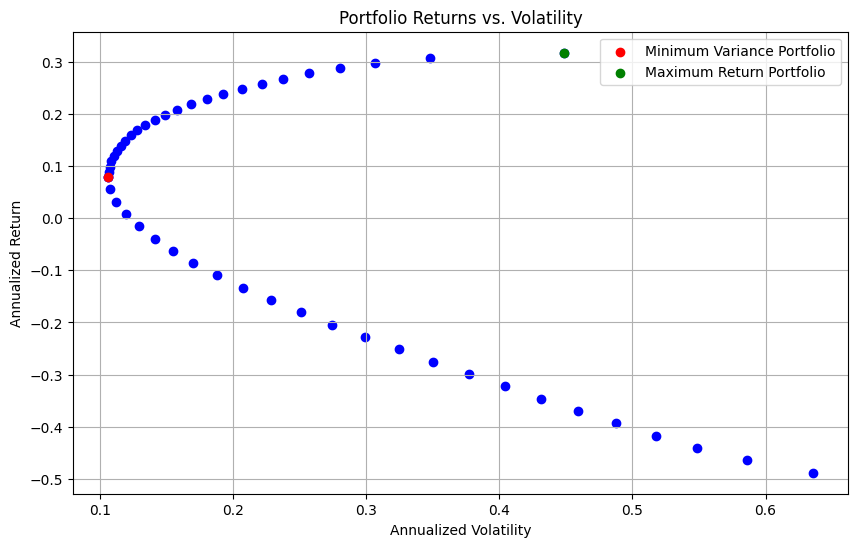

In [895]:
results_df['Annualized Volatility'] = results_df['Volatility'] * np.sqrt(12)
results_df['Annualized Return'] = results_df['Return'] * 12

index_gmv = results_df['Annualized Volatility'].idxmin()
index_max_return = results_df['Annualized Return'].idxmax()

# Tracé avec mise en évidence des portefeuilles spécifiques
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Annualized Volatility'], results_df['Annualized Return'], color='blue')
plt.scatter(results_df.loc[index_gmv, 'Annualized Volatility'], results_df.loc[index_gmv, 'Annualized Return'], color='red', label='Minimum Variance Portfolio')
plt.scatter(results_df.loc[index_max_return, 'Annualized Volatility'], results_df.loc[index_max_return, 'Annualized Return'], color='green', label='Maximum Return Portfolio')
plt.title('Portfolio Returns vs. Volatility')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

In [889]:
# Generate efficient frontier by varying target returns or risks
# Note: You can repeat the optimization for different target returns or risks
# and plot the resulting portfolios to create the efficient frontier
target_returns = np.linspace(min(avrg_returns), max(avrg_returns), num=20)
efficient_frontier = []
for target_return in target_returns:
    target_return_constraint = ({'type': 'eq', 'fun': lambda x: np.dot(x, avrg_returns) - target_return})
    efficient_portfolio = sco.minimize(result_long_only_gmv_portfolio, initialWeights, method='SLSQP', bounds = positivity_bounds, constraints=[cons, target_return_constraint])
    efficient_frontier.append((np.sqrt(result_long_only_gmv_portfolio(efficient_portfolio.x)), target_return))

# Plot the portfolios
plt.scatter(result_long_only_gmv_portfolio.fun, np.sqrt(min_var(result_long_only_gmv_portfolio.x)), label='Minimum Variance Portfolio', color='blue')
plt.scatter(-result_max_return_portfolio.fun, np.sqrt(min_var(result_max_return_portfolio.x)), label='Maximum Return Portfolio', color='red')
plt.plot([p[0] for p in efficient_frontier], [p[1] for p in efficient_frontier], label='Efficient Frontier', color='green')

# Add labels and legend
plt.xlabel('Expected Return')
plt.ylabel('Standard Deviation (Risk)')
plt.legend()

plt.show()


TypeError: 'OptimizeResult' object is not callable

In [ ]:
target_return = expected_GVM_return # Target return of GMW

def return_constraint(weights):
    # Calculate the expected portfolio return
    portfolio_return = np.dot(weights, expected_returns)
    # Subtract the target return to set up the equation as required
    return portfolio_return - target_return

# Adding the return constraint to the list of constraints
cons = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum of weights equals 1
    {'type': 'eq', 'fun': return_constraint})       # Portfolio return equals target return